# **PS4: VAEs, U-Nets, and Latent Diffusion**

Advanced Learning 2025/6.

Ibrahim Bashir


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 314992595
~~~

~~~
STUDENT GIT LINK: MISSING
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS4_LDM_2025_ID_[000000000].html`   

**IMPORTANT**: **Be sure to look the supplementary material at the end for some help!**

####**Imports + Google Drive**:

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import math

from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms, datasets

import scipy.io
from torchvision import transforms
import tarfile
from src4 import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In this assignment, we will be creating a latent diffusion model that will learn to generate new images of flowers with training done on the Flowers102 dataset. We suggest that you download the dataset directly from the website as the given .tgz (compressed) file from the original website source (under the 'Dataset images' download link): https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

And uploading that to google drive for ease of use.


Please mount your drive and import the objects in `src4.py` file (you can upload this to the session directly or from the drive) into the workspace:

In [28]:
#from google.colab import drive
#drive.mount('/content/drive')

In [29]:
save_dir = "/Users/netanelazran/Projects/ACL/HW4" # PATH TO THE **FOLDER** CONTAINING THE FLOWERS .tgz DATASET YOU UPLOADED TO YOUR GOOGLE DRIVE (THIS IS MIGHT BE A GOOD PLACE TO SAVE CHECKPOINTS DURING/POST TRAINING ALSO)



---



### **0. Loading and transforming data**

In [30]:
import os
import tarfile

tgz_path = os.path.join(save_dir, "102flowers.tgz")
new_data_dir = os.path.join(save_dir, "flowers102_extracted")

os.makedirs(new_data_dir, exist_ok=True)

with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(path=new_data_dir)

print("Extraction complete!")

Extraction complete!


In [31]:
class ImageOnlyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.paths = [
            os.path.join(root, f)
            for f in os.listdir(root)
            if f.lower().endswith((".jpg", ".png"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


#image_size = 96

#transform = transforms.Compose([
#    transforms.Resize(image_size),
#    transforms.CenterCrop(image_size), # Some augmentations to help mitigate overfitting
#    transforms.RandomHorizontalFlip(p=0.5), # Flowers look the same flipped
#    transforms.RandomApply([transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0))], p=0.85),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                        std=[0.5, 0.5, 0.5]) # Normalizes to -1 to 1
#])
image_size = 64

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

dataset = ImageOnlyDataset(
    "/Users/netanelazran/Projects/ACL/HW4/flowers102_extracted/jpg",
    transform
)

In [32]:
batch_size = 32
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0,      # IMPORTANT: disable multiprocessing on mac/jupyter
    pin_memory=False    # optional (keep False on CPU; on CUDA you can set True)
)

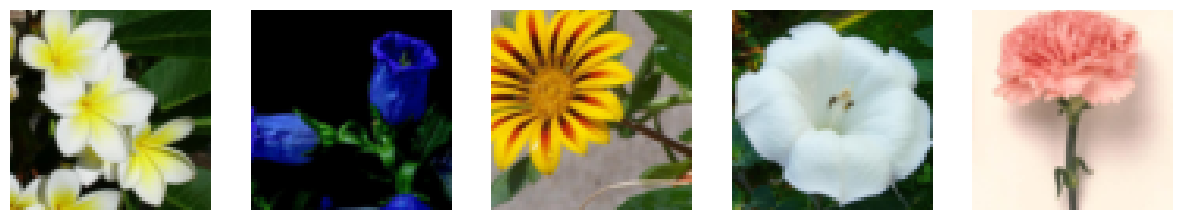

In [33]:
# Get one batch from the dataloader
images = next(iter(dataloader))  # shape [B, 3, H, W]

# If DataLoader returns (images, labels), keep only images
if isinstance(images, (list, tuple)):
    images = images[0]

# Randomly select 5 images from the batch
indices = random.sample(range(images.size(0)), 5)
sampled_images = images[indices]

# Denormalize [-1, 1] -> [0, 1] and permute to HWC for plotting
sampled_images = [(img * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()
                  for img in sampled_images]

# Plot 1x5
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img in zip(axes, sampled_images):
    ax.imshow(img)
    ax.axis('off')
plt.show()




---



### **PS4 Part 1: Attention and Residual Blocks** (10 points)

Please complete the missing code (`# YOUR SOLUTION`) so that the class works properly.    

You can deviate slightly from the recommended structure below, but please remain true to the class structure and compatibility with the rest of the network classes and functions. The idea here is to write YOUR OWN version of a latent diffusion model, so please try not to google the answers, or use ready-made functions from other libraries. I provided some very direct guidance (that is very similar, but not completely equivalent) in the supplementary material section to help guide architectural ideas.

####**A. Attention Block**

Here, you will write code to implement a multi-head self-attention (MHSA) mechanism applied to 2D feature maps. Your implementation should:
1. Apply GroupNorm to the input before computing queries, keys, and values (Q/K/V) (common in convolutional U-Nets to stabilize attention).
2. Compute multi-head self-attention over all spatial positions.
3. Include a residual connection by adding the input to the attention output.

**Note**: do not use the scaled_dot_product_attention function from pytorch

In [34]:
class SelfAttention(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        assert channels % num_heads == 0, "channels must be divisible by num_heads"

        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads

        # GroupNorm before QKV (like :Conv U-Nets)

        gn_groups = 32
        while channels % gn_groups != 0 and gn_groups > 1:
            gn_groups //= 2
        self.norm = nn.GroupNorm(gn_groups, channels)

        # QKV בעזרת 1x1 conv: (B,C,H,W) -> (B,3C,H,W)
        self.qkv = nn.Conv2d(channels, 3 * channels, kernel_size=1, bias=False)

        # Projection
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        """
        x: (B, C, H, W)
        returns: (B, C, H, W)
        """
        b, c, h, w = x.shape
        x_in = x  # residual

        # 1) GroupNorm before QKV
        x = self.norm(x)

        # 2) Compute Q, K, V
        qkv = self.qkv(x)                 # (B, 3C, H, W)
        q, k, v = torch.chunk(qkv, 3, dim=1)  # each (B, C, H, W)

        # 3) reshape (B, heads, N, head_dim) , N = H*W
        n = h * w
        q = q.view(b, self.num_heads, self.head_dim, n).transpose(2, 3)  # (B, heads, N, d)
        k = k.view(b, self.num_heads, self.head_dim, n).transpose(2, 3)  # (B, heads, N, d)
        v = v.view(b, self.num_heads, self.head_dim, n).transpose(2, 3)  # (B, heads, N, d)

        # 4) Attention weights: softmax( (QK^T)/sqrt(d) )
        scale = 1.0 / math.sqrt(self.head_dim)
        attn_logits = torch.matmul(q, k.transpose(-2, -1)) * scale        # (B, heads, N, N)
        attn = torch.softmax(attn_logits, dim=-1)                         # (B, heads, N, N)

        # 5) output = Attn @ V
        out = torch.matmul(attn, v)                                       # (B, heads, N, d)

        # 6) back to (B, C, H, W)
        out = out.transpose(2, 3).contiguous().view(b, c, h, w)           # (B, C, H, W)
        out = self.proj(out)

        # 7) Residual connection
        return x_in + out

####**B. Residual Blocks**

Implement a 2D residual block for convolutional feature maps. Your block should:
1. Apply GroupNorm → activation → convolution for the first layer.
2. A time embedding (`t_emb`) will be included for the later model (the U-Net for diffusion). You do not need to implement it (it is given), just be aware it will be used to modulate features via FiLM-style scaling and shifting in the upcoming U-Net.
3. Apply GroupNorm → activation → convolution for the second layer.
4. Include a skip connection: if the input and output channels differ, use a 1x1 convolution; otherwise, use the identity.
5. Return the sum of the processed features and the skip connection (residual addition).

In [35]:
def _gn_groups(channels: int) -> int:
    # Choose a GN group count that divides channels
    for g in (32, 16, 8, 4, 2, 1):
        if channels % g == 0:
            return g
    return 1


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None):
        super().__init__()

        # Optional time embedding projection (used in the U-Net, not the VAE)
        self.time_mlp = None
        if time_emb_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_emb_dim, out_channels * 2)  # scale + shift
            )

        self.act = nn.SiLU()

        # First layer: GN -> act -> conv
        self.norm1 = nn.GroupNorm(_gn_groups(in_channels), in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        # Second layer: GN -> act -> conv (FiLM may modulate after GN)
        self.norm2 = nn.GroupNorm(_gn_groups(out_channels), out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Skip connection: 1x1 conv if channels change, else identity
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip = nn.Identity()

    def forward(self, x, t_emb=None):
        x_skip = self.skip(x)

        # First block: GN -> act -> conv
        x = self.conv1(self.act(self.norm1(x)))

        if self.time_mlp is not None and t_emb is not None:  # Stable Diffusion–style FiLM conditioning
            time_encoding = self.time_mlp(t_emb)
            time_encoding = time_encoding.view(x.shape[0], x.shape[1] * 2, 1, 1)
            scale, shift = torch.chunk(time_encoding, 2, dim=1)
            x = self.norm2(x) * (1 + scale) + shift
        else:
            x = self.norm2(x)

        # Second block: act -> conv
        x = self.conv2(self.act(x))

        # Residual add
        return x + x_skip



---



### **PS4 Part 2: Variational Autoencoder** (40 points)

Recap:

A **Variational Autoencoder** (**VAE**) is a generative model that encodes inputs as a distribution over latent variables, typically Gaussian, rather than a single point. It is trained by maximizing the **evidence lower bound** (**ELBO**):
$$\text{ELBO} =
\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]
- \mathrm{KL}\big(q_\phi(z|x) \,\|\, p(z)\big)$$

To allow gradients to propagate through stochastic sampling, VAEs use the reparameterization trick, expressing the samples as $z = \mu + \sigma \cdot \epsilon$, with $\epsilon \sim \mathcal{N}(0, I)$.

Define your own **convolutional** VAE (i.e. no linear layers) using residual blocks (and optionally also attention blocks) you defined in the earlier section. The resnet blocks make it also a residual VAE, if you add attention also an attention-augmented VAE.

**Important**: make sure to give reasons for why you chose to implement the architecture you defined, and the process of your training at the end of the section where asked.

####**A. Encoder**

Implement a VAE encoder that maps an input image x to the latent space. Your implementation should:
1. Start with a convolution to process the input.
2. Include a series of stages, each consisting of one or more ResidualBlocks followed by downsampling (e.g., strided convolution). The idea is to gradually reduce spatial dimensions while increasing channels.
3. **Optionally**, you can include Self-Attention layers in later stage(s) for richer feature interactions. For a simple VAE, attention is optional.
4. End with a GroupNorm → activation → convolution that outputs `2 * latent_channels` channels. These will be split into:
    * Mean of the latent distribution
    * Log-variance of the latent distribution

Guidelines:

* The exact number of stages, channels, and residual blocks is up to you. This allows experimentation.

* We will later sample from the latent distribution using the reparameterization trick: `z = mu + eps * exp(0.5 * logvar)` with `eps ~ N(0, I)`.

* Think of your encoder as compressing the input while retaining enough information to reconstruct it via the decoder.
* Make sure the latent space is small enough to make the later diffusion model training less computationally demanding, but large enough to retain intermediate information for high fidelity decoding.

In [36]:
class VAE_Encoder(nn.Module):
    def __init__(self, in_channels: int = 3, latent_channels: int = 4):
        super().__init__()

        chs = [64, 128, 256, 512]

        self.conv_in = nn.Conv2d(in_channels, chs[0], kernel_size=3, padding=1)

        self.down1 = nn.ModuleList([
            ResidualBlock(chs[0], chs[0], time_emb_dim=None),
            ResidualBlock(chs[0], chs[0], time_emb_dim=None),
        ])
        self.ds1 = nn.Conv2d(chs[0], chs[1], kernel_size=4, stride=2, padding=1)

        self.down2 = nn.ModuleList([
            ResidualBlock(chs[1], chs[1], time_emb_dim=None),
            ResidualBlock(chs[1], chs[1], time_emb_dim=None),
        ])
        self.ds2 = nn.Conv2d(chs[1], chs[2], kernel_size=4, stride=2, padding=1)

        self.down3 = nn.ModuleList([
            ResidualBlock(chs[2], chs[2], time_emb_dim=None),
            ResidualBlock(chs[2], chs[2], time_emb_dim=None),
            SelfAttention(chs[2], num_heads=4),  # optional
        ])
        self.ds3 = nn.Conv2d(chs[2], chs[3], kernel_size=4, stride=2, padding=1)

        self.mid = nn.ModuleList([
            ResidualBlock(chs[3], chs[3], time_emb_dim=None),
            SelfAttention(chs[3], num_heads=8),  # optional
            ResidualBlock(chs[3], chs[3], time_emb_dim=None),
        ])

        self.norm_out = nn.GroupNorm(_gn_groups(chs[3]), chs[3])
        self.act = nn.SiLU()
        self.conv_out = nn.Conv2d(chs[3], 2 * latent_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor):
        h = self.conv_in(x)     # (B,64,H,W)

        for blk in self.down1:  # 64
            h = blk(h)
        h = self.ds1(h)         # -> 128

        for blk in self.down2:  # 128
            h = blk(h)
        h = self.ds2(h)         # -> 256

        for blk in self.down3:  # 256
            h = blk(h)
        h = self.ds3(h)         # -> 512

        for blk in self.mid:    # 512
            h = blk(h)

        h = self.conv_out(self.act(self.norm_out(h)))
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar

####**B. Decoder**

Implement a VAE decoder that maps a latent tensor `z` back to an image. Your implementation should:

1. Start with a convolution to process the latent input.
2. Include a series of stages, each consisting of one or more ResidualBlocks followed by upsampling (e.g., nearest-neighbor or transposed convolution). The idea is to gradually increase spatial dimensions while reducing channels.
3. **Optionally**, you can include Self-Attention layers in intermediate stages if desired, though again this is not required.
4. End with a GroupNorm → activation → convolution to produce the final image with `out_channels`.

Guidelines:

* Again, the number of stages, channels, and blocks is up to you.

* It is typically chosen to mirror the encoder, but with upsampling instead of downsampling. This is usually the simplest way to make the inverse problem well-posed and stable.

* Each upsampling stage should double the spatial size (or otherwise increase it toward the input resolution).

* Think of the decoder as reconstructing the input image from the compressed latent representation.

Hint: might need a further final step on the output.

In [37]:
class VAE_Decoder(nn.Module):
    def __init__(self, latent_channels=4, out_channels=3):
        super().__init__()

        # Mirror the encoder channel plan: 512 -> 256 -> 128 -> 64
        chs = [512, 256, 128, 64]

        self.act = nn.SiLU()

        # Input conv (latent -> features)
        self.conv_in = nn.Conv2d(latent_channels, chs[0], kernel_size=3, padding=1)

        # Bottleneck (optional attention)
        self.mid = nn.ModuleList([
            ResidualBlock(chs[0], chs[0], time_emb_dim=None),
            SelfAttention(chs[0], num_heads=8),
            ResidualBlock(chs[0], chs[0], time_emb_dim=None),
        ])

        # Upsample stage 1: 512 -> 256
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),
        )
        self.block1 = nn.ModuleList([
            ResidualBlock(chs[1], chs[1], time_emb_dim=None),
            ResidualBlock(chs[1], chs[1], time_emb_dim=None),
            SelfAttention(chs[1], num_heads=4),  # optional
        ])

        # Upsample stage 2: 256 -> 128
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),
        )
        self.block2 = nn.ModuleList([
            ResidualBlock(chs[2], chs[2], time_emb_dim=None),
            ResidualBlock(chs[2], chs[2], time_emb_dim=None),
        ])

        # Upsample stage 3: 128 -> 64
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),
        )
        self.block3 = nn.ModuleList([
            ResidualBlock(chs[3], chs[3], time_emb_dim=None),
            ResidualBlock(chs[3], chs[3], time_emb_dim=None),
        ])

        # Output head: GN -> act -> conv to image
        self.norm_out = nn.GroupNorm(_gn_groups(chs[3]), chs[3])
        self.conv_out = nn.Conv2d(chs[3], out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        h = self.conv_in(x)

        for blk in self.mid:
            h = blk(h)

        h = self.up1(h)
        for blk in self.block1:
            h = blk(h)

        h = self.up2(h)
        for blk in self.block2:
            h = blk(h)

        h = self.up3(h)
        for blk in self.block3:
            h = blk(h)

        h = self.conv_out(self.act(self.norm_out(h)))

        # Final step depends on input normalization (common if x in [-1, 1])
        return torch.tanh(h)

In [38]:
class VAE(nn.Module):
    def __init__(self, in_channels=3, latent_channels=4):
        super().__init__()
        self.encoder = VAE_Encoder(in_channels, latent_channels)
        self.decoder = VAE_Decoder(latent_channels, in_channels)

    def reparameterize(self, mu, logvar):
        """
        The 'Trick': Samples z from the distribution while
        allowing gradients to flow back to the encoder.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # 1. Map image to distribution parameters
        mu, logvar = self.encoder(x)

        # 2. Sample the latent representation
        z = self.reparameterize(mu, logvar)

        # 3. Reconstruct image from the sampled latent
        recon = self.decoder(z)

        return recon, mu, logvar

    @torch.no_grad()
    def encode(self, x):
        """Helper for the diffusion process: just get the latents."""
        mu, logvar = self.encoder(x)
        return self.reparameterize(mu, logvar)

    @torch.no_grad()
    def decode(self, z):
        """Helper for the diffusion process: turn latents to pixels."""
        return self.decoder(z)

####**C. VAE loss functions**

Maximizing: $\text{ELBO} = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]
- \mathrm{KL}\big(q_\phi(z|x) \,\|\, p(z)\big)$

Is equivalent to minimizing: $\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q_\phi(z|x)}[ - \log p_\theta(x|z)]
+ \mathrm{KL}\big(q_\phi(z|x) \,\|\, p(z)\big)$

Under the assumption that the reconstruction error follows a Gaussian distribution with fixed variance, maximizing the log-likelihood is mathematically equivalent to minimizing the Mean Squared Error (MSE). In this framework, the MSE serves as the negative log-likelihood, meaning the model that minimizes reconstruction error is also the one that maximizes the probability of the data.

The reconstruction loss is used to preserve the information needed to faithfully reconstruct the input from the encoding in the learning, while the Kullback–Leibler divergence loss term induces regularization of the latent space. More concretely, the KL term forces the latent distribution to be close to a standard normal so that sampling and generation are well-defined, granting generative validity in the latent space (essentially a penalty for not being Gaussian).

In simpler contexts such as ours, the reconstruction loss is typically chosen to the be mse or l1 loss (or additionally a Huber loss). You can also decide to choose to include them both and weight between them. As a sidenote/fun fact (no need to implement this yourself, it makes things much slower), more advanced applications typically include a perceptual loss, which is essentially looking at the mse/l1 loss between the feature maps after passing the images through a pretrained model (on something like ImageNet) like VGG16.

The KL term in the loss is given by:
$$\mathcal{L}_{KL} = -\frac{1}{2} \sum_{c=1}^{C} \sum_{h=1}^{H} \sum_{w=1}^{W} \Big( 1 + \text{logvar}_{c,h,w} - \mu_{c,h,w}^2 - e^{\text{logvar}_{c,h,w}} \Big)$$

In [39]:
def reconstruction_loss(recon_x, x):
    """
    Reconstruction loss as MSE (Gaussian NLL up to a constant).
    Returns a scalar averaged over the batch.
    """
    return F.mse_loss(recon_x, x, reduction="mean")


def kl_divergence_loss(mu, logvar):
    """
    KL(q(z|x) || p(z)) for diagonal Gaussian, summed over (C,H,W) and averaged over batch.
    mu/logvar shape: (B, C, H, W)
    """
    kl_per_elem = -0.5 * (1.0 + logvar - mu.pow(2) - logvar.exp())  # (B, C, H, W)
    kl_per_sample = kl_per_elem.sum(dim=(1, 2, 3))                  # (B,)
    return kl_per_sample.mean()                                     # scalar

The KL loss is usually downweighted in VAEs by $\beta$ in this context to let the latent retain rich, informative features instead of being forced too close to the prior, yielding  $\text{Loss} = \text{Recon} + \beta ⋅ \text{KL}$. This will usually need to be tuned by examining the avg. recon & avg. kl loss throughout initial training before being rerun. We typically set $\beta$ so that $\beta ⋅ \text{KL}$ is usually $1-10\%$ of the recosntruction loss (depends on how small you get your recon loss, for us $10\%$ worked well). When $\beta = 0$, this makes it a deterministic autoencoder, and for $\beta \neq 1$, a $\beta$-VAE. It can be helpful to have the weight start small in the start of training to promote closer reconstructions before, which is what we have below (you can change this so it stays fixed throughout training, this will depend on your architecture + initial runs after some analysis).

In [40]:
# DOWNWEIGHTING KL LOSS - **SUBJECT TO CHANGE ACCORDING TO YOUR MODEL RESULTS** ---- OPTIONAL ************ - "KL Weight Annealing"
kl_weight_start, kl_weight_end = 1e-6, 1e-4
warmup_epochs = 15

####**D. Training your VAE**

In this section, you will train your VAE. You are free to experiment with different hyperparameters and optimizers.

* **Epochs**: choose enough epochs to see meaningful reconstruction results. For our test model, we needed around 30 epochs, which at our model specification, required 3 minutes per epoch. You might need more/less, this will depend on some post-initial training analysis.
* **VAE instantiation**: create your VAE with your chosen `in_channels` and `latent_channels` (we implemented the same as done below).
* **Optimizer**: you can use Adam, AdamW, SGD, or any optimizer of your choice (we used Adam). Experiment with learning rates, weight decay, and other parameters.
* **Learning rate scheduler** (optional): you can use schedulers like `CosineAnnealingLR`, `StepLR`, or `ReduceLROnPlateau` (or any others of your choice). Adjust the scheduler parameters to match your number of epochs and learning rate.

Extra: you can change the batch size of the loader as well (though we used 32 as done earlier). For initial runs, I would look at the stats and outputs after 10-20 epochs, before committing to the rest of the training.

In [41]:
# NUMBER OF EPOCHS TO TRAIN VAE
vae_epochs = 30

# YOUR VAE
vae = VAE(in_channels=3, latent_channels=4).to(device)

# Optimizer
optimizer_vae = torch.optim.Adam(vae.parameters(), lr=2e-4, weight_decay=1e-4)

# Optional scheduler
scheduler_lr_vae = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_vae,
    T_max=vae_epochs,
    eta_min=2e-5
)

Include an explanation behind your chosen architecture, optimizer and hyperparams here (it doesn't need to be in-depth, just briefly explain what you saw from your initial runs/general process and what you changed according to what you saw):

We use a convolutional VAE with a hierarchical encoder–decoder structure based on ResidualBlocks.
The encoder gradually reduces spatial resolution while increasing the number of channels, producing a compact latent representation that is expressive enough for reconstruction but efficient for later diffusion modeling.
Self-attention is applied only in deeper layers where the spatial resolution is low, allowing global feature interactions without significant computational overhead.

The decoder mirrors the encoder using nearest-neighbor upsampling followed by convolutions and ResidualBlocks, which resulted in stable training and smooth reconstructions.
We use the Adam optimizer with a moderate learning rate, as it provided fast and stable convergence in initial runs.

The reconstruction loss is implemented as MSE under a Gaussian likelihood assumption, and the KL divergence regularizes the latent space toward a standard normal prior.
Based on early training behavior, we apply KL weight annealing to prevent the KL term from dominating too early, keeping its contribution relatively small compared to the reconstruction loss.

In [42]:
print("Starting VAE Training...")

for epoch in range(vae_epochs):
    vae.train()

    total_loss_sum = 0.0
    recon_loss_sum = 0.0
    kl_loss_sum = 0.0

    pbar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{vae_epochs}]", leave=False)

    if epoch < warmup_epochs:                                                                                                                                       # OPTIONAL ************
        kl_weight = kl_weight_start + (kl_weight_end - kl_weight_start) * (epoch / warmup_epochs)                                                                   # OPTIONAL ************
    else:                                                                                                                                                           # OPTIONAL ************
        kl_weight = kl_weight_end

    for batch_idx, images in enumerate(pbar, start=1):
        images = images.to(device)
        optimizer_vae.zero_grad()

        recon_images, mu, logvar = vae(images)

        recon_loss = reconstruction_loss(recon_images, images)
        kl_loss = kl_divergence_loss(mu, logvar)

        total_loss = recon_loss + kl_weight * kl_loss

        total_loss.backward()
        optimizer_vae.step()

        # accumulate
        total_loss_sum += total_loss.item()
        recon_loss_sum += recon_loss.item()
        kl_loss_sum += kl_loss.item()

        pbar.set_postfix({"loss": f"{total_loss_sum / batch_idx:.4f}", "recon": f"{recon_loss_sum / batch_idx:.4f}", "kl": f"{kl_loss_sum / batch_idx:.4f}"})

    scheduler_lr_vae.step()                                                                                                                                         # OPTIONAL ************

    print(
        f"==> Epoch {epoch+1} Complete | "
        f"Avg Total: {total_loss_sum / len(dataloader):.4f} | "
        f"Avg Recon: {recon_loss_sum / len(dataloader):.4f} | "
        f"Avg KL: {kl_loss_sum / len(dataloader):.4f}"
    )

    if (epoch + 1) % 5 == 0: # Saves model every 5 epochs incase training is interrupted
        checkpoint = {"epoch": epoch + 1, "vae_state_dict": vae.state_dict(), "optimizer_vae_state_dict": optimizer_vae.state_dict(), "scheduler_vae_state_dict": scheduler_lr_vae.state_dict()}
        torch.save(checkpoint, f"{save_dir}/vae_model.pt")


Starting VAE Training...


==> Epoch 1 Complete | Avg Total: 0.0876 | Avg Recon: 0.0866 | Avg KL: 974.1595


==> Epoch 2 Complete | Avg Total: 0.0404 | Avg Recon: 0.0357 | Avg KL: 614.3643


==> Epoch 3 Complete | Avg Total: 0.0393 | Avg Recon: 0.0323 | Avg KL: 494.5248


==> Epoch 4 Complete | Avg Total: 0.0411 | Avg Recon: 0.0320 | Avg KL: 433.6905


==> Epoch 5 Complete | Avg Total: 0.0428 | Avg Recon: 0.0321 | Avg KL: 393.2126


==> Epoch 6 Complete | Avg Total: 0.0444 | Avg Recon: 0.0321 | Avg KL: 361.6908


==> Epoch 7 Complete | Avg Total: 0.0467 | Avg Recon: 0.0330 | Avg KL: 338.0311


==> Epoch 8 Complete | Avg Total: 0.0482 | Avg Recon: 0.0333 | Avg KL: 316.5996


==> Epoch 9 Complete | Avg Total: 0.0499 | Avg Recon: 0.0338 | Avg KL: 298.5728


==> Epoch 10 Complete | Avg Total: 0.0516 | Avg Recon: 0.0345 | Avg KL: 283.4590


==> Epoch 11 Complete | Avg Total: 0.0529 | Avg Recon: 0.0349 | Avg KL: 269.6424


==> Epoch 12 Complete | Avg Total: 0.0546 | Avg Recon: 0.0356 | Avg KL: 257.4006


==> Epoch 13 Complete | Avg Total: 0.0562 | Avg Recon: 0.0364 | Avg KL: 246.0279


==> Epoch 14 Complete | Avg Total: 0.0576 | Avg Recon: 0.0371 | Avg KL: 235.8789


==> Epoch 15 Complete | Avg Total: 0.0585 | Avg Recon: 0.0373 | Avg KL: 226.9302


==> Epoch 16 Complete | Avg Total: 0.0600 | Avg Recon: 0.0381 | Avg KL: 218.2126


==> Epoch 17 Complete | Avg Total: 0.0598 | Avg Recon: 0.0381 | Avg KL: 217.4056


==> Epoch 18 Complete | Avg Total: 0.0597 | Avg Recon: 0.0379 | Avg KL: 217.1865


==> Epoch 19 Complete | Avg Total: 0.0591 | Avg Recon: 0.0374 | Avg KL: 217.0475


==> Epoch 20 Complete | Avg Total: 0.0589 | Avg Recon: 0.0373 | Avg KL: 216.3823


==> Epoch 21 Complete | Avg Total: 0.0587 | Avg Recon: 0.0371 | Avg KL: 216.0734


==> Epoch 22 Complete | Avg Total: 0.0585 | Avg Recon: 0.0369 | Avg KL: 216.2073


==> Epoch 23 Complete | Avg Total: 0.0583 | Avg Recon: 0.0367 | Avg KL: 216.3356


==> Epoch 24 Complete | Avg Total: 0.0581 | Avg Recon: 0.0365 | Avg KL: 216.0141


==> Epoch 25 Complete | Avg Total: 0.0580 | Avg Recon: 0.0364 | Avg KL: 216.0804


==> Epoch 26 Complete | Avg Total: 0.0577 | Avg Recon: 0.0362 | Avg KL: 215.5620


==> Epoch 27 Complete | Avg Total: 0.0577 | Avg Recon: 0.0361 | Avg KL: 215.7869


==> Epoch 28 Complete | Avg Total: 0.0575 | Avg Recon: 0.0359 | Avg KL: 215.7082


==> Epoch 29 Complete | Avg Total: 0.0574 | Avg Recon: 0.0358 | Avg KL: 215.8475


==> Epoch 30 Complete | Avg Total: 0.0573 | Avg Recon: 0.0358 | Avg KL: 215.6782


What to expect:
* **Phase 1**: early in training, the Reconstruction loss drops fast as the model learns to be a basic autoencoder.
* **Phase 2**: the KL loss might spike and then slowly descend. You are looking for a "knee" where the KL loss stabilizes at a non-zero value.
* **The "Sweet Spot"**: you want the KL loss to be small enough that the VAE can still reconstruct a flower with petals and texture, but large enough that the latent variables aren't exploding to infinity or becoming totally disjointed.

**Do not start your initial runs with the learning rate schedule**, you will first have to try to determine the optimal starting learning rate. Do this by running 1-5 epochs and see if there is a consistent drop in the initial recon loss, if it does not move or oscillate, the learning rate might be too high (or the KL term may be dominating), if it does go down but very slowly, it might be too small. Once you observe a stable and consistent decrease that plateaus (say within 5-25 epochs, depending on your own model and how long you will choose to train it), you can then introduce a learning rate schedule to check whether additional progress is possible or whether the model has almost effectively converged. Make sure to adjust (or warm up) the KL term accordingly too, as its weighting can interact with learning rate behavior.

It will also be helpful to look at the outputs of the vae as done below on training + unseen test images when you pause training, to see visually things are progressing (e.g. see if it captures the right colors, general composition, whether it is too blurry, etc).

If training is paused or interrupted and the session ends, you can re-instantiate your model and optimizer, and reload from the saved directory to resume training:

In [43]:
checkpoint_path = f"{save_dir}/vae_model.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)

vae.load_state_dict(checkpoint["vae_state_dict"])
optimizer_vae.load_state_dict(checkpoint["optimizer_vae_state_dict"])
scheduler_lr_vae.load_state_dict(checkpoint["scheduler_vae_state_dict"])
start_epoch = checkpoint["epoch"]

print(f"Resuming training from epoch {start_epoch}") # Then run the loop above again with range(start_epoch, vae_epochs)

Resuming training from epoch 30


Here is an example (on a random batch of training images) from our test model:

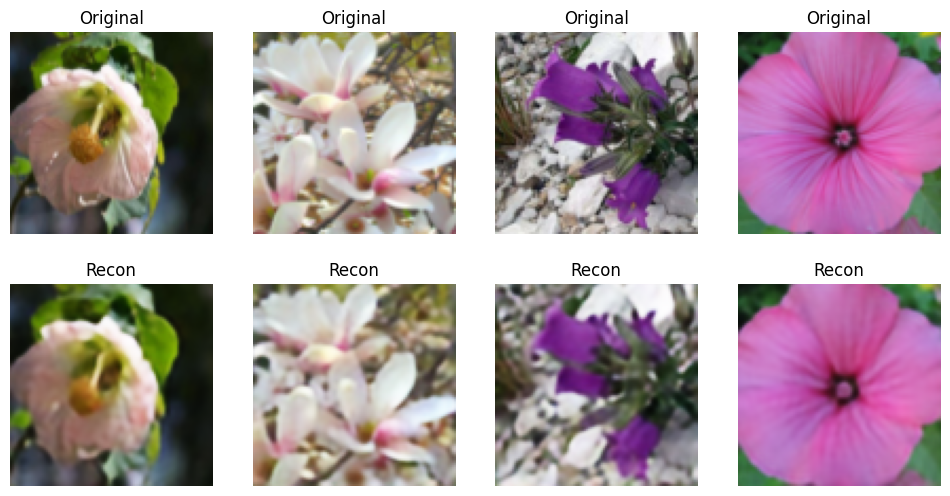

And yours:

In [53]:

@torch.no_grad()
def check_vae_quality(vae, dataloader, device=None, max_batches=1):
    if device is None:
        device = next(vae.parameters()).device

    vae.eval()

    total_recon = 0.0
    total_kl = 0.0
    n = 0

    for images in dataloader:
        if isinstance(images, (list, tuple)):
            images = images[0]

        images = images.to(device)

        recon, mu, logvar = vae(images)
        recon_loss = reconstruction_loss(recon, images)
        kl_loss = kl_divergence_loss(mu, logvar)

        total_recon += recon_loss.item()
        total_kl += kl_loss.item()
        n += 1

        if n >= max_batches:
            break

    print(
        f"[VAE quality check] "
        f"Recon: {total_recon / n:.4f} | "
        f"KL: {total_kl / n:.4f}"
    )

In [54]:
check_vae_quality(vae, dataloader) # Checking the output of the VAE on training images

[VAE quality check] Recon: 0.0357 | KL: 225.2452


Here is an example (on an unseen test image) from our test model:

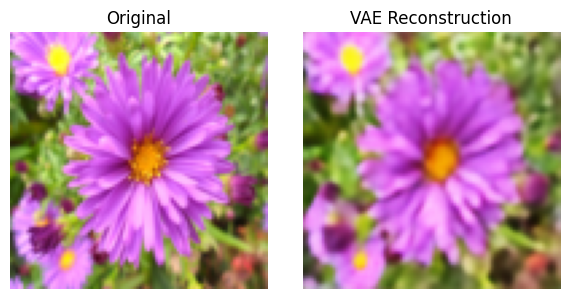

In [52]:

@torch.no_grad()
def check_single_image(vae, image_path, device=None):
    if device is None:
        device = next(vae.parameters()).device

    vae.eval()

    # Load image
    img = Image.open(image_path).convert("RGB")

    # IMPORTANT: use the SAME transform as training (except randomness)
    img_t = transform(img).unsqueeze(0).to(device)  # [1, 3, H, W]

    # Forward through VAE
    recon, mu, logvar = vae(img_t)

    # Move to CPU for plotting
    img_np = img_t[0].cpu().permute(1, 2, 0)
    recon_np = recon[0].cpu().permute(1, 2, 0)

    # If normalized to [-1,1], undo it
    img_np = (img_np * 0.5 + 0.5).clamp(0, 1)
    recon_np = (recon_np * 0.5 + 0.5).clamp(0, 1)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img_np)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(recon_np)
    axes[1].set_title("Reconstruction")
    axes[1].axis("off")

    plt.show()

And yours:

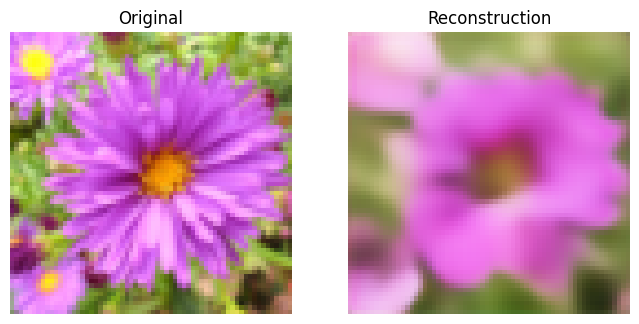

In [51]:
check_single_image(
    vae,
    "/Users/netanelazran/Projects/ACL/HW4/test_flower.jpg",
    device=device
)

Check to see it works okay on a variety of unseen test images, it is okay if it is a little blurry as above, the U-Net will help refine representations for the decoding (but not completely) for generated images.

Some supplementary stats to probe your model for a well-defined latent space (you can add this in the training loop to monitor results as training goes but it can slow things down a little bit):

In [58]:
#add independet function : infer_latent_shape (for the mext cell)
#@torch.no_grad()
#def infer_latent_shape(encoder, image_size, in_channels=3, device=None):
#    if device is None:
#        device = next(encoder.parameters()).device
#
#    dummy = torch.zeros(1, in_channels, image_size, image_size, device=device)
#    mu, _ = encoder(dummy)
#    return mu.shape[1:]  # (C, H, W)

In [ ]:
@torch.no_grad()
def get_detailed_stats(vae, dataloader, num_batches=255):
    vae.eval()
    all_mus = []
    all_logvars = []

    for i, batch in enumerate(dataloader):
        if i >= num_batches: break
        images = batch[0] if isinstance(batch, (list, tuple)) else batch
        images = images.to(next(vae.parameters()).device)

        mu, logvar = vae.encoder(images)
        all_mus.append(mu.flatten())
        all_logvars.append(logvar.flatten())

    all_mus = torch.cat(all_mus)
    all_logvars = torch.cat(all_logvars)
    latent_shape = infer_latent_shape(vae.encoder, images.shape[2], in_channels=3, device=None)
    channel_stds = all_mus.view(-1, *latent_shape).std(dim=(0, 2, 3))

    stats = {
        "mu_mean": all_mus.mean().item(),
        "mu_std": all_mus.std().item(),
        "mu_range": [all_mus.min().item(), all_mus.max().item()],
        "channel_stds": channel_stds,
        "logvar_mean": all_logvars.mean().item(),
        "scaling_factor": 1.0 / all_mus.std().item()
    }
    return stats

get_detailed_stats(vae, dataloader)

The latent space learned by the VAE is well-centered around zero (mu_mean ≈ 0.008) and exhibits a controlled spread (mu_std ≈ 0.845). Latent values remain within a reasonable range (≈ [−5.9, 4.8]), indicating adequate KL regularization without extreme outliers. Channel-wise statistics are balanced, showing that all latent channels are utilized without collapse. The moderate average log-variance (logvar_mean ≈ −1.73) reflects controlled stochasticity in the encoder. Overall, the latent representation is stable and suitable for training a latent diffusion model without further adjustments.

* `mu_mean` - target: 0.0. Measures the global center of data in latent space. Keep this as close to zero as possible. If it drifts significantly (e.g., >∣0.5∣), the Diffusion model will have to waste capacity "shifting" the noise toward the data before it can start denoising.
* `mu_std` - target: 1.0. Measures the spread of latent vectors. If it’s too high (>1), the latent noise will have unusually large magnitude, making the U-Net harder to train. If it is much higher than 1.0 (e.g., 5.0+), you must use a Scaling Factor (like the 0.18215 in Stable Diffusion) to rescale latent vectors to unit variance, before training the u-net (which our code below will already do automatically).
* `mu_range` - target: Narrow (e.g., ±5 to ±10). Detects extreme outliers. If the range is massive (e.g., ±100), it usually indicates KL regularization is too weak. The U-Net will likely produce "deep-fried" or over-saturated images because extreme latent values are hard to map back to realistic images. (will depend on the size of the images)
* `channel_stds` - target: Roughly Equal. You want all channels to have similar standard deviations. If three channels are 1.2 and one is 0.01, you have a "dead channel." This usually means your latent space is too large for the complexity of the data, or your KL weight is too high.
* `logvar_mean` - target: Highly Negative (e.g., −5 to −10). Represents the "noise" or "blurriness" the encoder is adding. In Latent Diffusion, we want very low noise (high certainty), because the latent representations are already fairly precise, making denoising easier. A very negative value means the encoder is placing images at precise points, almost deterministic, which preserves high-frequency details like textures and petals but reduce stochasticity. If it's too high (close to 0), it introduces a lot of noise into the latent space, which makes training the U-Net harder. (will depend on the size of the images)

Output of our test model:
`{'mu_mean': -0.023,
 'mu_std': 1.028,
 'mu_range': [-5.909, 5.931],
 'channel_stds': tensor([0.949, 0.916, 0.803, 1.333], device='cuda:0'),
 'logvar_mean': -7.289,
 'scaling_factor': 0.972}`



---



At this point, sampling from our latent space to generate new images of flowers can be quite bad... Here is an example from our model:

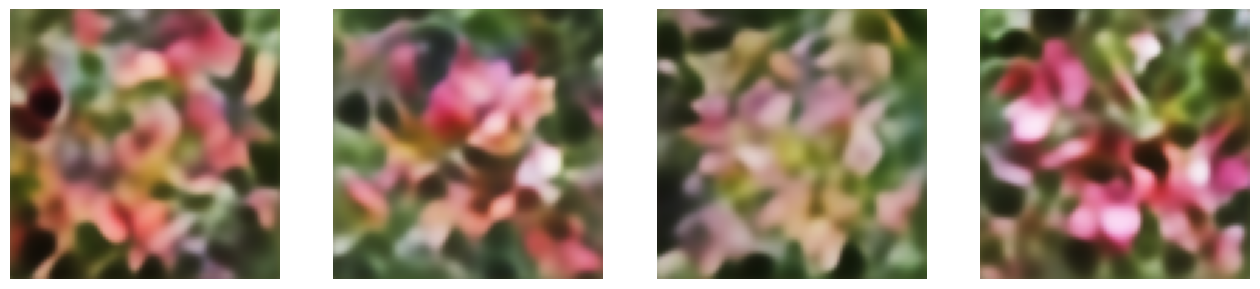

In [59]:
vae.eval()
device = next(vae.parameters()).device

batch_size = 4
latent_shape = infer_latent_shape(vae.encoder, image_size=96)
z = torch.randn((batch_size, *latent_shape), device=device) # change according to size of your latent space

with torch.no_grad():
    x_hat = vae.decoder(z)

x_hat = (x_hat.clamp(-1, 1) + 1) / 2

plt.figure(figsize=(16, 4))
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(x_hat[i].permute(1, 2, 0).cpu())
    plt.axis("off")
plt.show()


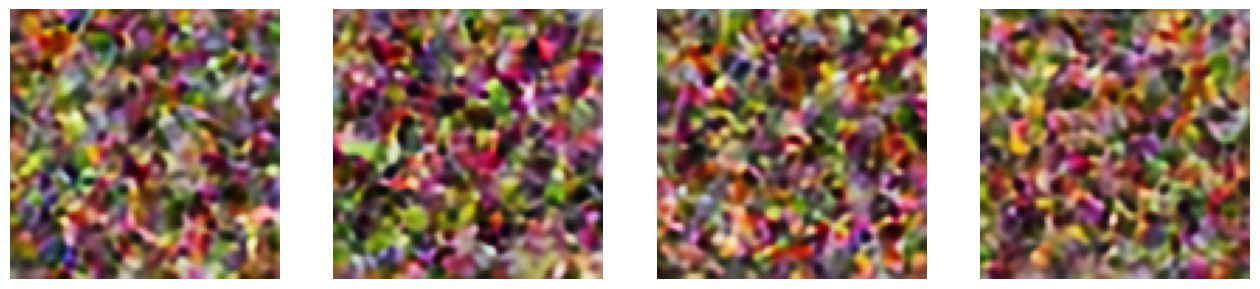

To this end, to generate new images of flowers (and whatever else we want) we can train a u-net to be able to take a fully noisy latent representation and learn to denoise it iteratively through a sequence of steps. We do this by training it to detect and subtract noise over several steps gradually. Each step corresponds to a different noise level or timestep. The `t_emb` defined in the beginning encodes the current timestep into a vector that the U-Net can use to condition its predictions. By incorporating the time embedding, the U-Net knows how much noise is present and can adjust its processing accordingly, producing more accurate denoising. Technically, it is often applied via FiLM-style modulation: scaling and shifting feature maps, so the network can adapt its activations for each timestep (this is the standard in modern architectures, there are earlier or other versions that do this differently).

In short: `t_emb` tells the U-Net where it is in the denoising process, enabling it to progressively turn noise into a coherent image according to where it is in the progression.



---



### **PS4 Part 3: Diffusion U-Net** (40 points)

Diffusion models operate by transforming a simple probability distribution (usually Gaussian noise) into a complex data distribution, such as natural images, through a learned iterative process. This framework consists of a forward Markov chain that systematically adds noise to the data $x_0$ over $T$ steps. The transition probability at any given step $t$ is defined as:

\begin{equation}
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t \mathbf{I})
\end{equation}

where $\beta_t$ represents a pre-defined variance schedule. The generative capability of the model is found in the reverse diffusion process. In this phase, a neural network is trained to approximate the reverse conditional probability:

\begin{equation}
p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
\end{equation}

By optimizing the model to predict the added noise, the training objective can be simplified to a mean squared error loss:

\begin{equation}
\mathcal{L}_{simple}(\theta) = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
\end{equation}

This allows the model to start from pure noise and iteratively "denoise" the sample until it recovers a high-fidelity image that matches the learned training distribution. Diffusion however, is quite computationally expensive (we will need to train a very large model to learn the mapping between usually tens of thousands of steps at large dimensions).

**Latent diffusion** uses a VAE to separate perceptual compression from semantic generation, allowing the diffusion process to happen in a lower-dimensional "latent space" rather than on raw pixels. The encoder reduces the computational burden by compressing high-resolution images into the compact representations, while the decoder ensures that the final denoised latent can be reconstructed into a visually detailed, high-fidelity image. This way we can sample a lower dimensional noisy latent representation and using our diffusion model (trained along that lower dimension) to refine it before giving it to our decoder (and allow us to use many less timesteps to train the diffusion model as well).

The code for training will already be given, essentially it works by taking our clean images, getting the known clean latents using our pretrained VAE encoder, randomly choose a timestep $t$ and add a specific amount of Gaussian noise as determined by the noise scheduler. The model is trained to predict what the noise is given the timestep we are at, and we compare according to the actual amount of noise we added via a standard loss like MSE.

####**A. Making Our Noise Scheduler**

The noise scheduler controls how much noise is added to latent representations over the timesteps during the forward diffusion (noising) process. It defines a schedule of noise strengths (betas) that gradually corrupts the latent vector, enabling the model to learn denoising.

For example, a linear schedule will have the noise increase linearly over time and the model will see gradually more noise at each step in a uniform, predictable way. As we can see in the image below. The linear schedule however, may not always emphasize early or late timesteps optimally. In a cosine scheduler, the noise follows a cosine curve across timesteps. Here, noise increases slowly at first, faster in the middle, then slows at the end. This usually enables the model to better the capture structure in early steps, often yields better sample quality.

Here, before building our own diffusion model, we will build our noise scheduler.

Key Methods:

1. Write code that will define the `self.betas` according to the `cosine` (or whatever else you want, this is just what we used) schedule. This is done by:

Compute $\bar{\alpha}_t = \frac{\cos^2\Big(\frac{t/T + s}{1+s} \frac{\pi}{2}\Big)}{\cos^2\Big(\frac{s \pi}{2(1+s)}\Big)}$, where $T$ is the total number of timesteps, $s$ is a small offset (e.g. 0.008) to prevent extremely small betas, then define the betas as $\beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}$, for each $t = 0, \dots, T$.

2. `add_noise(z_0, t, noise)`: adds noise to a latent vector $z_0$ according to timestep $t$ using given sample noise (forward diffusion).

That is, compute: $z_t = \sqrt{\bar{\alpha}_t} z_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon $,  where $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$ and $\epsilon$ is Gaussian noise. Note that $\bar{\alpha}$ is already precomputed by `self.alphas_cumprod`.

3. `step(eps_pred, t, z_t)`: standard DDPM-style denoising step (reverse diffusion), that computes $z_{t-1}$ given $z_t$ and the predicted noise $\epsilon_{\text{pred}}$.

That is, compute:
$$z_{t-1} = \frac{1}{\sqrt{\alpha}_t} \Big( z_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\text{pred}} \Big) + \sqrt{\text{Var}[z_{t-1} | z_t]} \eta$$
where: the posterior variance $\text{Var}[z_{t-1} | z_t] = \beta_t \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}$, and $\eta \sim \mathcal{N}(0,I)$ (same shape as $z_t$, except we do not add any noise if $t=0$, producing the final clean latent). The whole expression of the first term in $z_{t-1}$ represents the posterior mean.

In [65]:
import sys
sys.path.append("/Users/netanelazran/Projects/ACL/HW4")

from src4 import visualize_noise_progression

In [60]:
class NoiseScheduler:
    """DDPM-style noise scheduler supporting linear and cosine beta schedules.

    Notes:
      - t is assumed to be an integer timestep index in [0, num_timesteps-1].
      - add_noise implements: z_t = sqrt(alpha_bar_t) z_0 + sqrt(1-alpha_bar_t) * eps
      - step implements the standard DDPM reverse update using eps_pred.
    """

    def __init__(self, num_timesteps: int = 1000,
                 beta_start: float = 1e-4,
                 beta_end: float = 0.02,
                 schedule: str = 'linear'):
        self.num_timesteps = int(num_timesteps)

        if schedule == 'linear':
            self.betas = torch.linspace(beta_start, beta_end, self.num_timesteps)

        elif schedule == 'cosine':
            # Cosine schedule from: alpha_bar(t) = cos^2(((t/T + s)/(1+s)) * pi/2) / cos^2((s/(1+s))*pi/2)
            # betas: beta_t = 1 - alpha_bar(t)/alpha_bar(t-1)
            s = 0.008
            T = self.num_timesteps

            # We build alpha_bar for t = 0..T (inclusive) to compute ratios.
            steps = torch.arange(0, T + 1, dtype=torch.float32)
            f = (steps / T + s) / (1.0 + s)
            alpha_bar = torch.cos(f * math.pi / 2.0) ** 2

            # Normalize so alpha_bar[0] = 1
            alpha_bar = alpha_bar / alpha_bar[0]

            betas = 1.0 - (alpha_bar[1:] / alpha_bar[:-1])  # length T
            self.betas = torch.clip(betas, 1e-4, 0.9999)

        else:
            raise ValueError(f"Unknown schedule='{schedule}'. Use 'linear' or 'cosine'.")

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def _to_device(self, device: torch.device):
        """Convenience: move precomputed tensors to the device of the latents."""
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alphas_cumprod = self.alphas_cumprod.to(device)

    def add_noise(self, z_0: torch.Tensor, t: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        """Forward diffusion: add noise to clean latents z_0 at timestep t using provided noise."""
        device = z_0.device
        self._to_device(device)

        # Ensure t is a tensor of shape [B]
        if isinstance(t, int):
            t = torch.tensor([t], device=device, dtype=torch.long)
        else:
            t = t.to(device=device, dtype=torch.long)
            if t.ndim == 0:
                t = t.view(1)

        # alpha_bar_t: [B]
        alpha_bar_t = self.alphas_cumprod.gather(0, t).view(-1, 1, 1, 1)

        sqrt_alpha_bar = torch.sqrt(alpha_bar_t)
        sqrt_one_minus = torch.sqrt(1.0 - alpha_bar_t)

        z_t = sqrt_alpha_bar * z_0 + sqrt_one_minus * noise
        return z_t

    def step(self, eps_pred: torch.Tensor, t: torch.Tensor, z_t: torch.Tensor) -> torch.Tensor:
        """Reverse diffusion: compute z_{t-1} given z_t and predicted noise eps_pred."""
        device = z_t.device
        self._to_device(device)

        # Ensure t is a tensor of shape [B]
        if isinstance(t, int):
            t = torch.tensor([t], device=device, dtype=torch.long)
        else:
            t = t.to(device=device, dtype=torch.long)
            if t.ndim == 0:
                t = t.view(1)

        # Gather scalars per batch
        beta_t = self.betas.gather(0, t).view(-1, 1, 1, 1)
        alpha_t = self.alphas.gather(0, t).view(-1, 1, 1, 1)
        alpha_bar_t = self.alphas_cumprod.gather(0, t).view(-1, 1, 1, 1)

        # alpha_bar_{t-1} (define as 1 for t=0)
        t_prev = torch.clamp(t - 1, min=0)
        alpha_bar_prev = self.alphas_cumprod.gather(0, t_prev).view(-1, 1, 1, 1)
        alpha_bar_prev = torch.where((t.view(-1, 1, 1, 1) == 0), torch.ones_like(alpha_bar_prev), alpha_bar_prev)

        # Posterior variance: beta_t * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)
        posterior_variance = beta_t * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t)
        posterior_variance = torch.clamp(posterior_variance, min=1e-20)
        posterior_variance_sqrt = torch.sqrt(posterior_variance)

        # Posterior mean (DDPM):
        # mu = 1/sqrt(alpha_t) * ( z_t - (1-alpha_t)/sqrt(1-alpha_bar_t) * eps_pred )
        coef = (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t)
        posterior_mean = (1.0 / torch.sqrt(alpha_t)) * (z_t - coef * eps_pred)

        noise = torch.randn_like(z_t)

        # No noise when t == 0
        no_noise_mask = (t == 0).view(-1, 1, 1, 1)
        z_prev = torch.where(no_noise_mask, posterior_mean, posterior_mean + posterior_variance_sqrt * noise)
        return z_prev


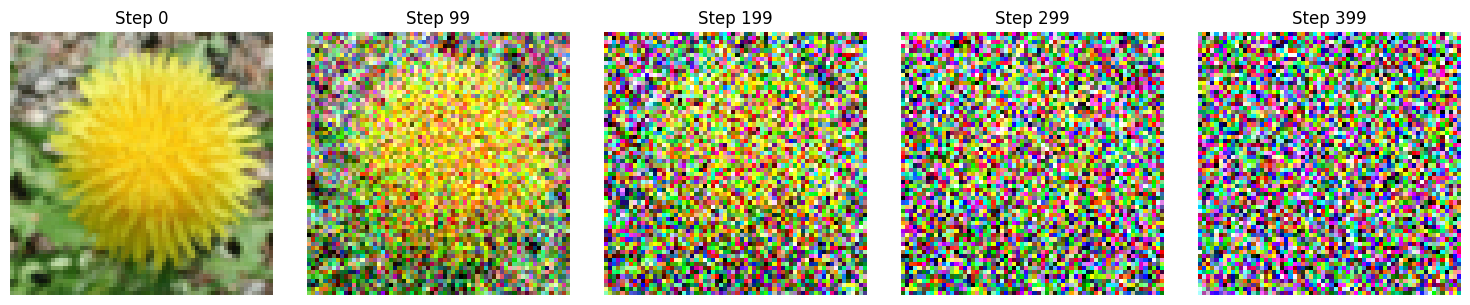

In [66]:
from src4 import visualize_noise_progression
scheduler = NoiseScheduler(num_timesteps=400, schedule='linear')
visualize_noise_progression(dataloader, scheduler)

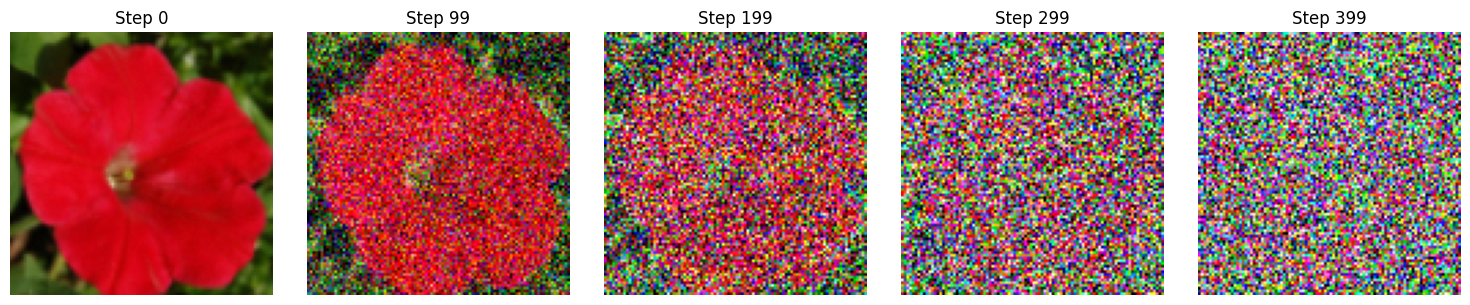

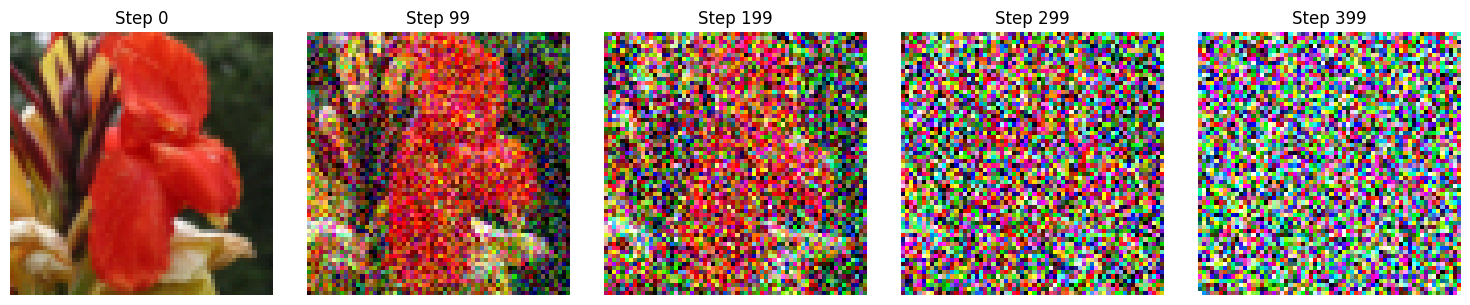

In [67]:
scheduler = NoiseScheduler(num_timesteps=400, schedule='cosine') # After you give your solution
visualize_noise_progression(dataloader, scheduler)

####**B. Building your U-Net Model**

You will probably not learn U-Nets in class (though it was briefly introduced in the guest lecture), but thankfully it will be fairly straightforward to implement given all the code we have up to this point. A U-Net is an encoder–decoder architecture with skip connections that allow low-level spatial details to bypass the bottleneck and be reused during reconstruction. Its distinctive "U" shape consists of an encoder that compresses the noisy input to capture high-level context and a decoder that reconstructs the spatial details (by gradually decreasing and increasing the spatial resolution, and gradually increasing then decreasing the channels), connected by skip connections that preserve fine-grained information from the original noisy image.

Keep in mind that since we are implementing a latent diffusion model, we having the U-Net working along the latent space of the VAE rather than the images

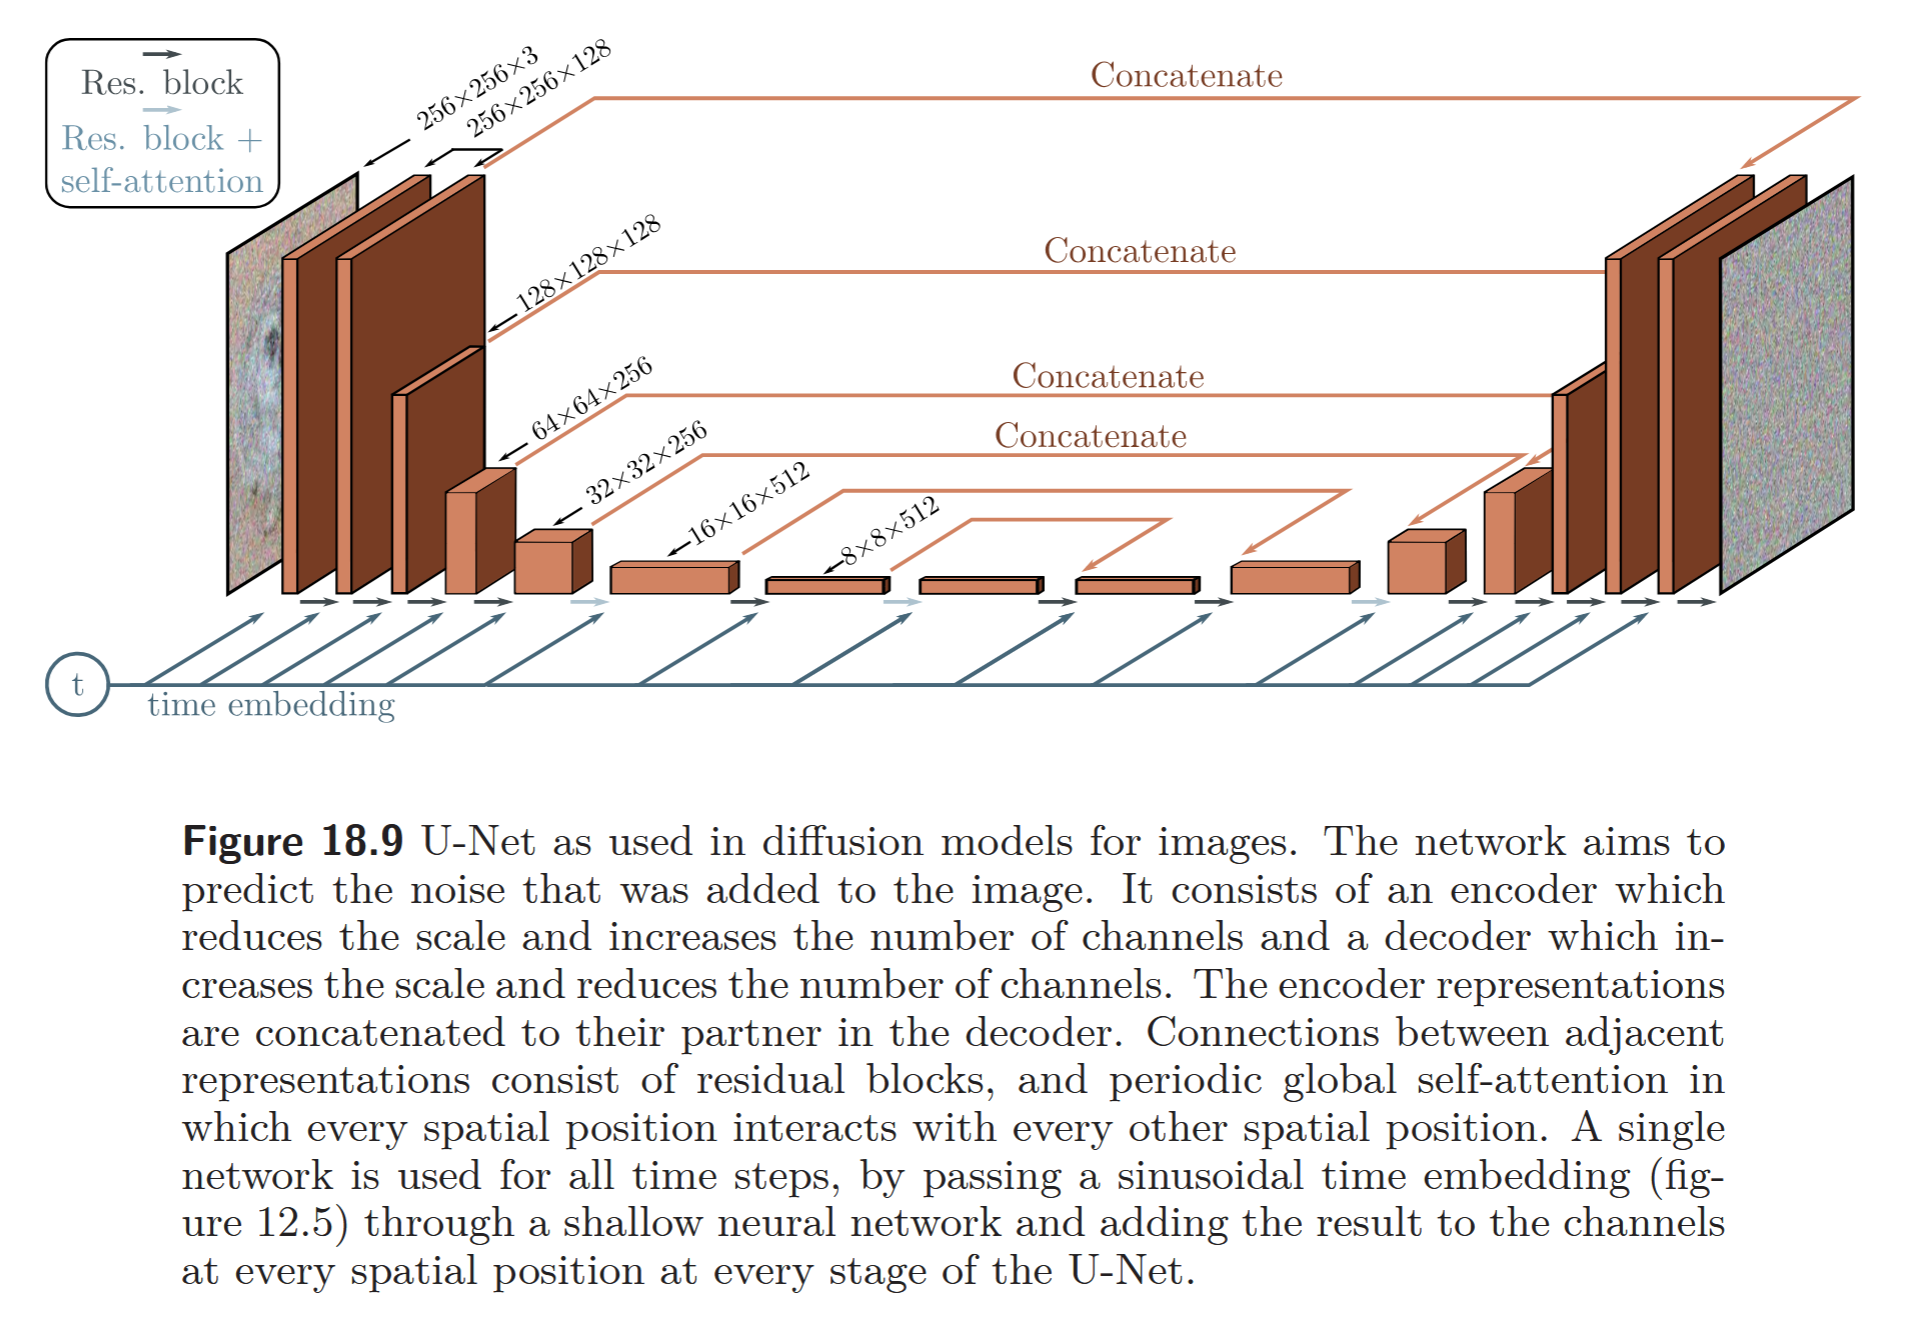

You will now implement a U-Net architecture for diffusion, which predicts the noise present in a latent representation at a given diffusion timestep.

This model operates entirely in latent space (not pixel space) and takes as input:
* a noisy latent tensor $x \in \mathbb{R}^{B×C×H×W}$
* a timestep index $t \in \mathbb{N}^{B}$

It outputs a tensor of the same shape as $x$, representing the predicted noise $\hat{\epsilon}$. B is for the batch size, C for the number of latent channels produced by VAE encoder (the default we have is 4 as before), and H, W being the spatial resolution of the latent feature map which is determined by the amount downsampled by your architectural choices in the VAE encoder (you won't need to compute or define H, W since everything is essentially convolutional).

Your Diffusion U-Net should follow the standard encoder–bottleneck–decoder structure with:

* Residual blocks for stable deep learning

* Self-attention blocks at lower resolutions to capture global structure

* Skip connections between encoder and decoder layers

* Time conditioning via a learned time embedding (`t_emb`)

Instructions:
1. **Time Embedding**: Use the provided `time_mlp `to embed the timestep t into a vector `t_emb` (already done for you). This embedding must be passed into every residual block in the network, e.g. `ResidualBlock(base_channels, base_channels, time_embed_dim)`.
2. **Downsampling Path** (Encoder): Construct a series of resolution levels to process the latent features:
    * Apply one or more `ResidualBlock`'s at each resolution level.
    * Crucial Step: Store the intermediate activations from each level to be used later as skip connections.
    * Reduce the spatial resolution using strided convolutions or pooling layers.
    * Optional: Include `SelfAttention` block(s) at the lower-resolution levels to capture long-range dependencies (computationally cheaper at lower levels).
3. **Bottleneck**: At the lowest spatial resolution:
    * Apply a sequence of `ResidualBlock` and `SelfAttention` layers in the order you want.
    * This stage acts as the "bridge" of the U-Net, processing the most compressed global information before upsampling begins.
4. **Upsampling Path** (Decoder): Reverse the downsampling process to return to the original latent resolution:
    * Increase the spatial resolution (e.g., using nearest-neighbor `nn.Upsample` followed by a convolution).
    * Concatenate the corresponding skip connection from the encoder path along the channel dimension (e.g. `torch.cat([x, skip], dim=1)`)..
    * Apply `ResidualBlock`'s to refine features.
    * It is common practice to mirror the attention blocks used in the encoder path if implemented in the encoder.
5. **Final Output**: After reaching the original latent resolution, apply a final normalization and a 3×3 (or other) convolution to map the internal feature channels back to the required number of latent channels (e.g., 4). (we did this for you).

Extra pointers:
- It is common to increase the channel dimension as spatial resolution decreases (e.g., doubling channels after each downsampling step).
- Note that `nn.Sequential` does not support passing two arguments (e.g. support passing two arguments, e.g. `x` and `t_emb`), use `nn.ModuleList` instead if you want.  
- Be sure to look at the structure of the code given in the supplementary material for some further guidance.

In [72]:
class ResBlock(nn.Module):
    """
    Residual block with time embedding injection.
    - x: (B, C, H, W)
    - t_emb: (B, time_embed_dim)
    """
    def __init__(self, in_ch: int, out_ch: int, time_embed_dim: int, groups: int = 32):
        super().__init__()
        assert in_ch > 0 and out_ch > 0

        # Use a safe groups number (must divide channels)
        g1 = min(groups, in_ch)
        while in_ch % g1 != 0:
            g1 -= 1

        g2 = min(groups, out_ch)
        while out_ch % g2 != 0:
            g2 -= 1

        self.norm1 = nn.GroupNorm(g1, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)

        self.time_proj = nn.Linear(time_embed_dim, out_ch)

        self.norm2 = nn.GroupNorm(g2, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

        if in_ch != out_ch:
            self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        else:
            self.skip = nn.Identity()

        self.act = nn.SiLU()

    def forward(self, x, t_emb):
        h = self.conv1(self.act(self.norm1(x)))

        # Inject time embedding: (B, out_ch) -> (B, out_ch, 1, 1)
        t = self.time_proj(self.act(t_emb)).unsqueeze(-1).unsqueeze(-1)
        h = h + t

        h = self.conv2(self.act(self.norm2(h)))
        return h + self.skip(x)


class Downsample(nn.Module):
    """Halve spatial resolution (H,W) -> (H/2, W/2)"""
    def __init__(self, ch: int):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    """Double spatial resolution (H,W) -> (2H, 2W)"""
    def __init__(self, ch: int):
        super().__init__()
        self.tconv = nn.ConvTranspose2d(ch, ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.tconv(x)


class DiffusionUNet(nn.Module):
    def __init__(self, latent_channels=4, base_channels=128, time_embed_dim=None):
        super().__init__()

        # Time Embedding Setup, typically time_dim is 4x the base channels
        if time_embed_dim is None:
            time_embed_dim = base_channels * 4

        self.time_mlp = nn.Sequential(
            SinusoidalEmbeddings(base_channels),
            nn.Linear(base_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Initial Convolution
        self.conv_in = nn.Conv2d(latent_channels, base_channels, kernel_size=3, padding=1)

        # -------------------------
        # YOUR SOLUTION (U-Net body)
        # -------------------------

        ch1 = base_channels
        ch2 = base_channels * 2
        ch3 = base_channels * 4

        # Down path
        self.down1_block1 = ResBlock(ch1, ch1, time_embed_dim)
        self.down1_block2 = ResBlock(ch1, ch1, time_embed_dim)
        self.down1_downsample = Downsample(ch1)

        self.down2_block1 = ResBlock(ch1, ch2, time_embed_dim)
        self.down2_block2 = ResBlock(ch2, ch2, time_embed_dim)
        self.down2_downsample = Downsample(ch2)

        # Bottleneck
        self.mid_block1 = ResBlock(ch2, ch3, time_embed_dim)
        self.mid_block2 = ResBlock(ch3, ch3, time_embed_dim)
        self.mid_block3 = ResBlock(ch3, ch2, time_embed_dim)

        # Up path
        self.up2_upsample = Upsample(ch2)
        self.up2_block1 = ResBlock(ch2 + ch2, ch2, time_embed_dim)  # concat with skip from down2 (ch2)
        self.up2_block2 = ResBlock(ch2, ch1, time_embed_dim)

        self.up1_upsample = Upsample(ch1)
        self.up1_block1 = ResBlock(ch1 + ch1, ch1, time_embed_dim)  # concat with skip from down1 (ch1)
        self.up1_block2 = ResBlock(ch1, ch1, time_embed_dim)

        # Output head
        self.norm_out = nn.GroupNorm(32, base_channels)
        self.conv_out = nn.Conv2d(base_channels, latent_channels, kernel_size=3, padding=1)
        self.act = nn.SiLU()

    def forward(self, x, t):
        # 1. Embed Time
        t_emb = self.time_mlp(t)

        # 2. Initial Conv
        x1 = self.conv_in(x)

        # 3. Down stage(s) + store skip(s)
        d1 = self.down1_block1(x1, t_emb)
        d1 = self.down1_block2(d1, t_emb)
        skip1 = d1
        d1_down = self.down1_downsample(d1)

        d2 = self.down2_block1(d1_down, t_emb)
        d2 = self.down2_block2(d2, t_emb)
        skip2 = d2
        d2_down = self.down2_downsample(d2)

        # 4. Bottleneck
        m = self.mid_block1(d2_down, t_emb)
        m = self.mid_block2(m, t_emb)
        m = self.mid_block3(m, t_emb)

        # 5. Up stage(s) + concat skip(s)
        u2 = self.up2_upsample(m)
        u2 = torch.cat([u2, skip2], dim=1)
        u2 = self.up2_block1(u2, t_emb)
        u2 = self.up2_block2(u2, t_emb)

        u1 = self.up1_upsample(u2)
        u1 = torch.cat([u1, skip1], dim=1)
        u1 = self.up1_block1(u1, t_emb)
        h = self.up1_block2(u1, t_emb)

        h = self.norm_out(h)
        h = self.act(h)  # nonlinearity as required
        out = self.conv_out(h)
        return out

In [77]:
stats = get_detailed_stats(vae, dataloader, num_batches=255)
scaling_factor = stats["scaling_factor"]
print("Scaling factor:", scaling_factor)

Scaling factor: 1.1838679064013355


####**C. Training your U-Net**

As before, you can instantiate your model however you like (just make sure it is compatible with the VAE), and you can use different noise schedules, optimizers, learning rate schedulers, and you will need to find an optimal set of hyperparams as according to initial test runs. Our test model was trained for 50 epochs, at around 1 min 20 seconds per epoch, and we would look at the outputs of the generations after 20 epochs to see if it is working alright, before committing to the the rest of the training. If you will choose to implement a lr scheduler, again, start off without it, analyze the loss, and choose to add it in with the appropriate values accordingly. It will be helpful to see the progress of the model's generative capacity as you progress through training (e.g. check how generated/sampled flowers look like after 20-30 epochs) before committing to the rest of the training.

In [83]:
# Number of diffusion training epochs
diffusion_epochs = 15  # enough to see stable training and decreasing loss

# UNet model
unet = DiffusionUNet(
    latent_channels=4,
    base_channels=128
).to(device)

# Noise scheduler (cosine schedule is recommended)
scheduler = NoiseScheduler(
    num_timesteps=1000,
    schedule='cosine'
)

# Optimizer (SAFE values for diffusion)
optimizer_unet = torch.optim.AdamW(
    unet.parameters(),
    lr=1e-5,          # stable learning rate for diffusion
    weight_decay=1e-4 # small weight decay (important for AdamW)
)

# Learning rate scheduler (optional but stable)
scheduler_lr_unet = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_unet,
    T_max=diffusion_epochs,
    eta_min=1e-6      # small, non-zero minimum learning rate
)

Include an explanation behind your chosen architecture, optimizer and hyperparams here (it doesn't need to be in-depth, just briefly explain what you saw from your initial runs and what you changed according to what you saw):

The diffusion model is implemented as a U-Net in the VAE latent space to reduce computational cost while preserving semantic structure. Residual blocks and skip connections ensure stable training and effective information flow, while self-attention at lower resolutions captures global dependencies. Time conditioning is applied using sinusoidal embeddings to allow timestep-aware denoising.

AdamW was chosen for its stability in diffusion training. Initial runs with higher learning rates were unstable, so the learning rate was reduced, resulting in smoother convergence. A cosine noise schedule was used to better preserve structure in early diffusion steps.

In [84]:
for epoch in range(diffusion_epochs):

    unet.train()
    vae.eval()  # VAE is frozen
    total_loss = 0.0
    pbar = tqdm(dataloader, desc="Training batches", leave=False)

    for batch_idx, images in enumerate(pbar, start=1):
        images = images.to(device)

        # 1. Get clean latents (z_0) + Scale
        with torch.no_grad():
            mu, logvar = vae.encoder(images)
            z_0 = reparameterize(mu, logvar) * scaling_factor

        # 2. Sample random timesteps and noise
        batch_size = images.shape[0]
        t = torch.randint(0, scheduler.num_timesteps, (batch_size,), device=device)
        noise = torch.randn_like(z_0)

        # 3. Add noise to latents (Forward process)
        z_t = scheduler.add_noise(z_0, t, noise)

        # 4. Predict noise and backprop
        optimizer_unet.zero_grad()
        pred_noise = unet(z_t, t)
        loss = F.mse_loss(pred_noise, noise)                               #  MSE LOSS
        loss.backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)    # REMOVE IF YOU WANT
        optimizer_unet.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{total_loss / batch_idx:.6f}"})

    scheduler_lr_unet.step()

    print(f"Diffusion Epoch {epoch + 1} | Loss: {total_loss / len(dataloader):.6f}")
    if (epoch + 1) % 10 == 0: # saves model every 10 epochs
        checkpoint2 = {
            "epoch": epoch + 1, # next epoch to run
            "unet_state_dict": unet.state_dict(),
            "optimizer_unet_state_dict": optimizer_unet.state_dict(),
            "scheduler_unet_state_dict": scheduler_lr_unet.state_dict(),   # REMOVE IF NOT USING !!!!
            "scaling_factor": scaling_factor
            }
        torch.save(checkpoint2, f"{save_dir}/unet_model.pt")

Diffusion Epoch 1 | Loss: 0.759036


Diffusion Epoch 2 | Loss: 0.620622


Diffusion Epoch 3 | Loss: 0.571421


Diffusion Epoch 4 | Loss: 0.558843


Diffusion Epoch 5 | Loss: 0.545108


Diffusion Epoch 6 | Loss: 0.544566


Diffusion Epoch 7 | Loss: 0.541334


Diffusion Epoch 8 | Loss: 0.535495


Diffusion Epoch 9 | Loss: 0.535798


Diffusion Epoch 10 | Loss: 0.546002


Diffusion Epoch 11 | Loss: 0.530361


Diffusion Epoch 12 | Loss: 0.536632


Diffusion Epoch 13 | Loss: 0.532015


Diffusion Epoch 14 | Loss: 0.539059


Diffusion Epoch 15 | Loss: 0.532246




---



Just as before, if training is paused or interrupted and the session ends, you can re-instantiate your model and optimizer, and reload from the saved directory to resume training:

In [94]:
checkpoint_path2 = f"{save_dir}/unet_model.pt"
checkpoint2 = torch.load(checkpoint_path2, map_location=device)

unet.load_state_dict(checkpoint2["unet_state_dict"])
optimizer_unet.load_state_dict(checkpoint2["optimizer_unet_state_dict"])
scheduler_lr_unet.load_state_dict(checkpoint2["scheduler_unet_state_dict"])
scaling_factor = checkpoint2["scaling_factor"]
start_epoch2 = checkpoint2["epoch"]

print(f"Resuming training from epoch {start_epoch2}") # Then run the loop above again with range(start_epoch2, diffusion_epochs)

Resuming training from epoch 10




---



### **PS4 Part 4: Generating New Images By Latent Diffusion** (10 points)

At this point, we are (hopefully) ready to generate new images using our new Latent Diffusion Model. We will define a unified class (already given to you), which will use our models + scheduler to sample and iteratively denoise a latent representation into new images!

In [87]:
class LatentDiffusion(nn.Module):
    def __init__(self, vae, unet, scheduler, scaling_factor):
        super().__init__()
        self.vae = vae
        for param in self.vae.parameters():
            param.requires_grad = False

        self.unet = unet
        self.scheduler = scheduler
        self.scaling_factor = scaling_factor

    def get_latent(self, x):
        """Maps pixels to scaled latent space."""
        z = self.vae.encode(x)
        return z * self.scaling_factor

    def decode_latent(self, z):
        """Maps scaled latents back to pixels."""
        z = z / self.scaling_factor
        return self.vae.decode(z)


In [88]:
def run_ddpm(ldm_model, latent_shape, num_steps=999, seed=None):
    ldm_model.unet.eval()
    ldm_model.vae.eval()
    device = next(ldm_model.parameters()).device

    if seed:
        torch.manual_seed(seed)

    # Start with the SAME starting noise for both
    z_ddpm = torch.randn((1, *latent_shape), device=device)

    with torch.no_grad():
        for t_val in reversed(range(0, num_steps)):
            t = torch.full((1,), t_val, device=device, dtype=torch.long)
            eps_pred = ldm_model.unet(z_ddpm, t)
            z_ddpm = ldm_model.scheduler.step(eps_pred, t, z_ddpm)

        img_ddpm = ldm_model.decode_latent(z_ddpm)

    # Visualization
    img = (img_ddpm[0].cpu().permute(1, 2, 0).numpy() + 1) / 2
    plt.figure(figsize=(4, 4))
    plt.imshow(img.clip(0, 1))
    plt.axis('off')
    plt.show()

latent_shape = infer_latent_shape(vae.encoder, image_size=96)
ldm_model = LatentDiffusion(vae, unet, scheduler, scaling_factor)

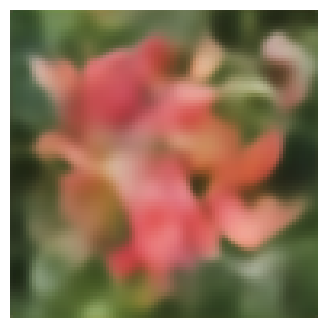

In [89]:
run_ddpm(ldm_model, latent_shape, num_steps=10, seed=42)     # RUN

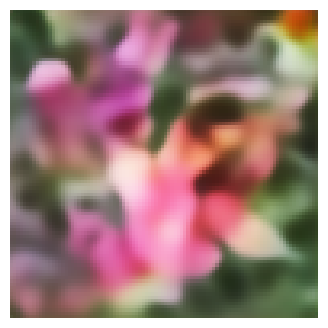

In [90]:
run_ddpm(ldm_model, latent_shape, num_steps=750, seed=42)    # RUN

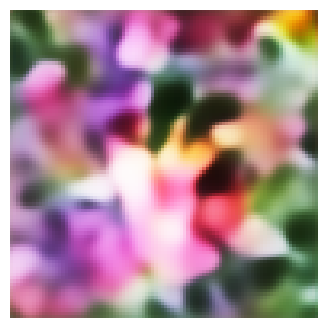

In [91]:
run_ddpm(ldm_model, latent_shape, num_steps=950, seed=42)    # RUN

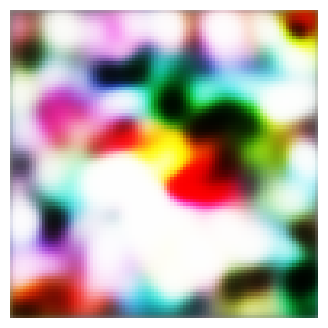

In [92]:
run_ddpm(ldm_model, latent_shape, num_steps=999, seed=42)    # RUN (change if you ended up using more/less timesteps for your scheduler during training)

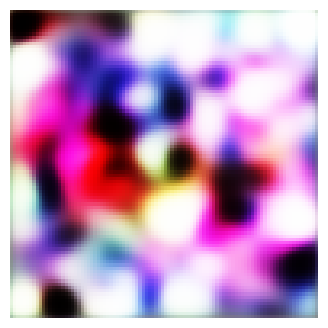

In [93]:
run_ddpm(ldm_model, latent_shape, num_steps=999, seed=None)  # RUN (setting seed to None to sample + generate different flowers)

Here are some sample images created by our test model for comparison!

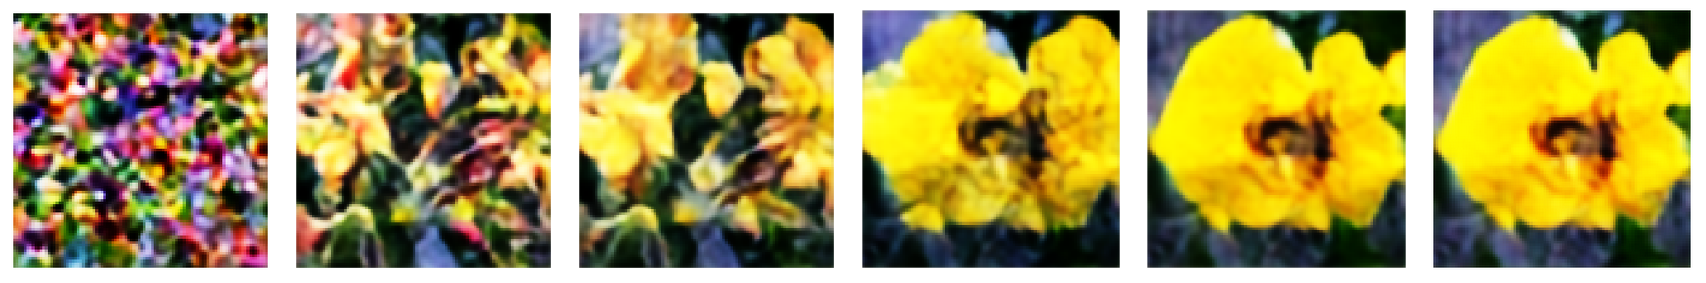

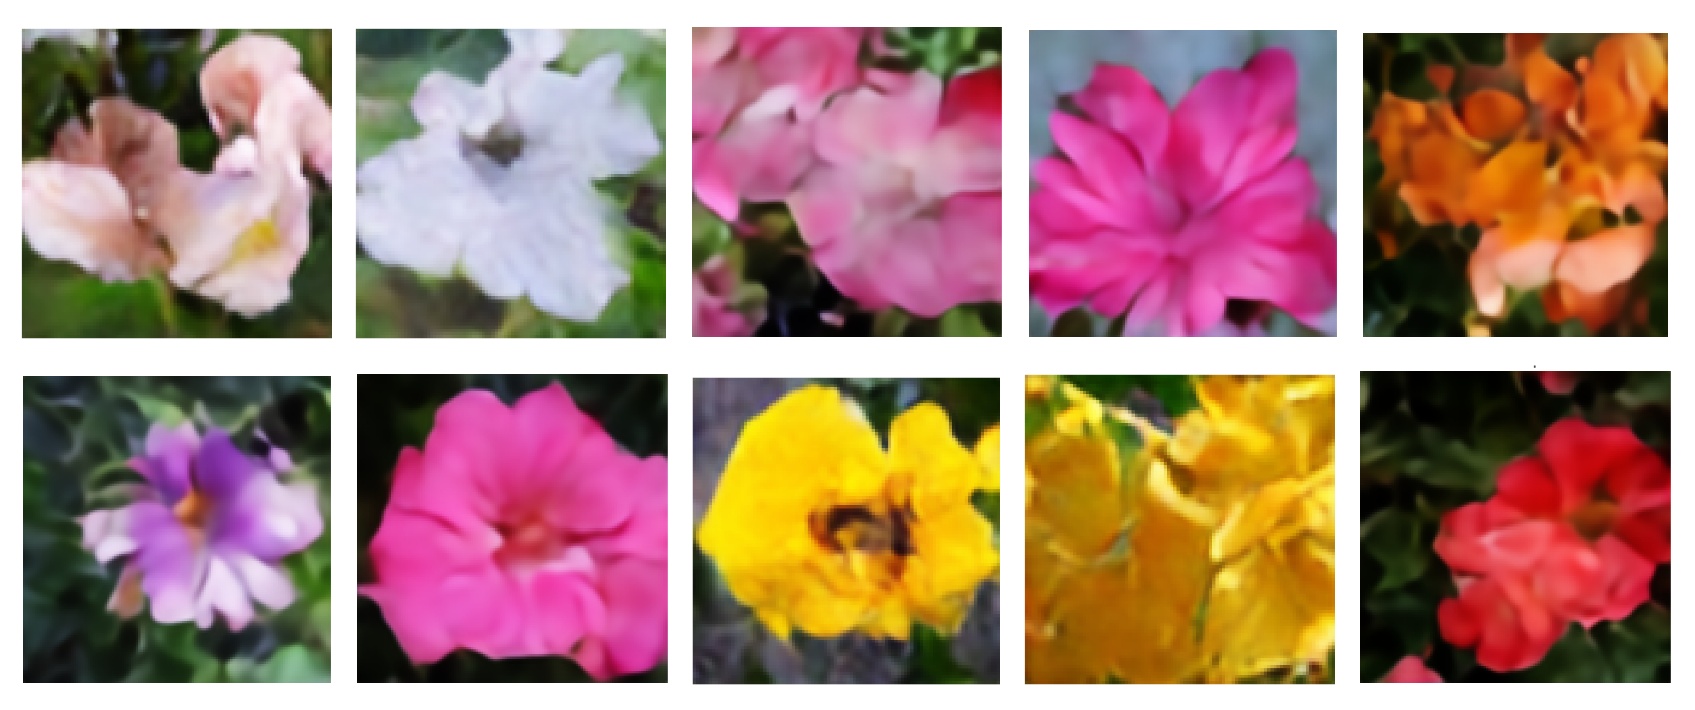

Your images don't have to be SOTA or detailed, but they are expected to be coherent (i.e. to actually be able to see a flower with petals).

####**Questions**:

a. Do you think your model performs well? Why or why not?  



b. What would you change to improve it?



c. In a VAE, the total loss is defined as $\text{Loss} = \text{Recon} + \beta ⋅ \text{KL}$. If we set $\beta=0$, the model effectively becomes a standard Autoencoder. Describe the likely visual quality of the reconstructions in this scenario, and explain what would happen to the latent space and the consequences that would come up to the diffusion model.



d. Explain the trade-off between reconstruction accuracy and latent regularization in a VAE. Why is this trade-off particularly important for downstream diffusion models?



e. A person reports that their VAE has reached a state where the KL loss is near zero, and the model outputs the exact same 'blurry flower' regardless of which input image is provided. Define this phenomenon and explain which loss term the optimizer is 'cheating' to achieve this result (you can google this, but try to understand what is going on).



f. How does the choice of noise schedule (e.g., linear vs cosine) affect training stability and sample quality in latent diffusion?




## ANSWER

a.

Yes, the model performs reasonably well, but there is still clear room for improvement.

The latent diffusion pipeline functions correctly: the diffusion U-Net trains stably, the loss decreases smoothly, and the model is able to generate coherent images rather than pure noise. The generated samples exhibit recognizable global structure, consistent color distributions, and overall flower-like shapes, indicating that the model has learned meaningful patterns in the latent space.

However, the visual quality is limited. Many samples lack fine details and appear blurry, with occasional structural artifacts. This is expected given the relatively small model size, the limited number of diffusion training epochs, and the constrained latent representation produced by the VAE. In addition, long-range dependencies and high-frequency details are only partially captured.

In summary, the model successfully demonstrates the core principles of latent diffusion and produces valid samples, but higher visual fidelity would require longer training, a larger U-Net, and potentially a higher-capacity VAE or improved training schedules.

# b
1.	Insufficient Diffusion Training
The diffusion U-Net was trained for too few epochs, which limits convergence and results in blurry samples.
2.	Limited U-Net Model Capacity
The U-Net architecture is relatively small, reducing its ability to capture fine-grained details and complex structures.
3.	Suboptimal VAE Reconstruction Quality
The VAE produces soft reconstructions, which constrains the upper bound on image quality achievable by the diffusion model.
4.	Basic Sampling Strategy
Image generation relies on a simple sampling setup with a limited number of steps, without refinement techniques that improve sharpness and stability.

⸻


c.

When β = 0, the KL term is removed and the model becomes a standard autoencoder.

Reconstruction quality:
Reconstructed images would usually appear sharper and close
r to the input, since the model focuses only on minimizing reconstruction error. This is consistent with what we observed when KL regularization was weak—images become visually cleaner but less robust.

Latent space behavior:
Without KL regularization, the latent space becomes unstructured and non-Gaussian. Latent representations are no longer centered or smoothly distributed, unlike our trained VAE where mu_mean stayed close to 0 and the variance was controlled. Sampling or interpolating in this space becomes unreliable.

Impact on diffusion:
Latent diffusion relies on a well-behaved, approximately Gaussian latent space. With β = 0, the diffusion model would struggle to denoise from pure noise because the noise distribution would not align with the latent data distribution, leading to unstable training and poor generations.

d . 

In a VAE, there is a trade-off between reconstruction accuracy and latent regularization. Emphasizing reconstruction (low β) leads to sharper images but results in an unstructured, non-Gaussian latent space. Emphasizing regularization (high β) produces a smoother, well-behaved latent space but causes blurrier reconstructions due to information loss.

This trade-off is especially important for diffusion models, which rely on a structured, approximately Gaussian latent space to add and remove noise effectively. If regularization is too weak, diffusion becomes unstable; if it is too strong, important semantic details are lost. A balanced trade-off is therefore essential for stable diffusion training and high-quality generation.

e. 

This phenomenon is called posterior collapse.

Posterior collapse happens when the encoder learns to output latent distributions that are almost identical to the prior distribution (usually a standard normal). This drives the KL loss very close to zero, meaning the latent variables no longer carry meaningful information about the input image.

To still minimize the overall loss, the decoder adapts by ignoring the latent code entirely and learning to output a single average reconstruction, which typically appears blurry (such as a generic “mean flower”) regardless of the input. This behavior reduces the reconstruction loss in an average sense, even though individual reconstructions are poor.

In this situation, the optimizer is effectively “cheating” the KL loss: instead of balancing reconstruction and latent regularization, it collapses the posterior to match the prior. This prevents the model from learning a useful latent space and eliminates the generative benefits of the VAE.

f.

The noise schedule directly affects how difficult the denoising task is at different timesteps, which in turn impacts training stability and sample quality.

A linear noise schedule increases noise uniformly over time. This often injects relatively large amounts of noise early in training, making early denoising steps harder to learn and sometimes leading to unstable gradients or overly smooth samples.

A cosine noise schedule adds noise slowly at early timesteps, increases it more strongly in the middle, and tapers off near the end. This gives the model more opportunity to learn coarse structure before dealing with heavily corrupted latents. As a result, cosine schedules typically lead to more stable training, faster convergence, and higher-quality samples with better structure and fewer artifacts.

Overall, cosine schedules are better aligned with the learning dynamics of diffusion models and are usually preferred for latent diffusion.



---



### **Supplementary Material**


Code:

* Here is code that implements a U-net only implementation very similar to this assignment, also on Oxford Flowers (with attention, but meant for a lower resolution images): https://github.com/filipbasara0/simple-diffusion/blob/main/simple_diffusion/model/unet.py

* Here is a notebook that does a U-Net only implementation, also to Oxford Flowers 102 (but without attention): https://github.com/RajeshAndra/Flower-Image-Generation-Using-Diffusion/blob/main/diffusion-model-pytorch.ipynb

* Here is a notebook that does a much simpler architecture of our implementation but to CIFAR-10 (and without attention): https://github.com/nikhilchatta/LatentDiffusion/blob/main/LatentDiffusion.ipynb


* Here is a notebook that does a much simpler architecture of our implementation but to MNIST (and without attention): https://colab.research.google.com/github/ehonig/vdm-pytorch/blob/main/SimpleDiffusionColab_PyTorch.ipynb#scrollTo=aSUTpFYUpEhd


Some good videos:

* [But how do AI images and videos actually work? | Guest video by Welch Labs](https://youtu.be/iv-5mZ_9CPY?si=AQKjAWd2Ziqyfb9o)
* [ Diffusion Models: DDPM | Generative AI Animated ](https://youtu.be/EhndHhIvWWw?si=h8dXe736w7Xx1-v5)
* [Coding Stable Diffusion from scratch in PyTorch](https://youtu.be/ZBKpAp_6TGI?si=6-UD6r2QQoekQhiZ) (keep in mind we are implementing an unconditional LDM, while this video also implements text conditioning e.g. with a prompt "rose" to generate a rose instead of just any flower, which goes a little further, but besides that the architecture is very similar).

Reading:

* If you want more info on the derivations and the intuition behind VAE's and diffusion models, I reccomend looking at the corresponding sections given by the book "Understanding Deep Learning" by Simon J.D. Prince, 2024. A link can be found here: https://anthology-of-data.science/resources/prince2023udl.pdf
* [ What are Diffusion Models? ](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
* [Diffusion Models, Introductory + Additional Resources](https://github.com/diff-usion/Awesome-Diffusion-Models#introductory-posts)




---



###**Given Helper Functions**

Functions in `src4.py`:

- `SinusoidalEmbeddings`: Converts discrete integer timesteps into high-dimensional vector representations using sine and cosine functions of varying frequencies.
- `check_vae_quality`: Evaluates the VAE by passing a batch from the dataloader through the model and plotting side-by-side comparisons of original and reconstructed images.
- `check_single_image`: Processes a specific image from a file path to visualize how well the VAE can reconstruct an individual, 'out-of-distribution' sample.
- `infer_latent_shape`: Determines the spatial dimensions and channel count of the latent space by passing a dummy tensor through the encoder.
- `visualize_noise_progression`: Displays the forward diffusion process by taking a real image and showing it at various stages of corruption according to the noise schedule.
- `sample_from_distribution`, `reparameterize`: Implements the reparameterization trick to allow backpropagation through stochastic layers by sampling from a Gaussian distribution defined by the model's predicted mean and variance.
- `calculate_scaling_factor`: Computes a normalization constant based on the standard deviation of latents across multiple batches to ensure the latent space has unit variance for the diffusion model.
